#  Analyse  for holo at AuxTel for Scan data

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date :November 2nd 2021


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

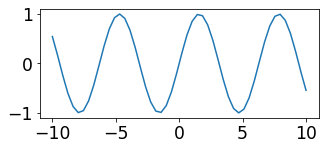

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [7]:
string_date

'2021-11-03'

In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.7.0'

In [10]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [11]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [12]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [13]:
from time import sleep

In [14]:
from astropy.time import Time
import astropy.units as u

# Function

In [15]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^holo4_003_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target(filename):
    m = re.findall('^holo4_003_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

# Config

In [16]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [17]:
version="v4.0"

# Path

In [18]:
HOSTCC=False

In [19]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/softs/github/lsst/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

In [20]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [21]:
! ls -l /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000234_quickLookExp/basespec

total 19384
-rw-r--r--  1 dagoret  staff      607 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_lines.csv
-rw-r--r--  1 dagoret  staff  4970880 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_spectrogram.fits
-rw-r--r--  1 dagoret  staff  4754880 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_spectrum.fits
-rw-r--r--  1 dagoret  staff   191794 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_table.csv


In [22]:

# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

# Logbook for file selection

In [23]:
# Logbook for scan data
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_'+ version+'.csv'

In [24]:
df=pd.read_csv(filename_logbook,index_col=0)

In [25]:
pd.set_option('display.max_rows', None)

In [26]:
df

index                     date  \
0        0  2021-07-08T02:50:31.569   
1        1  2021-07-08T02:51:12.101   
2        2  2021-07-08T02:51:21.256   
3        3  2021-07-08T02:51:30.934   
4        4  2021-07-08T02:51:40.885   
5        5  2021-07-08T02:51:50.381   
6        6  2021-07-08T02:51:59.759   
7        7  2021-07-08T02:52:10.113   
8        8  2021-07-08T02:52:19.262   
9        9  2021-07-08T02:52:29.022   
10      10  2021-07-08T03:09:18.381   
11      11  2021-07-08T03:09:51.483   
12      12  2021-07-08T03:10:22.899   
13      13  2021-07-08T03:10:54.635   
14      14  2021-07-08T03:14:25.113   
15      15  2021-07-08T03:18:49.728   
16      16  2021-07-08T03:22:35.058   
17      17  2021-07-08T03:27:28.637   
18      18  2021-07-08T03:31:49.398   
19      19  2021-07-08T03:33:02.383   
20      20  2021-07-08T03:33:40.416   
21      21  2021-07-08T03:34:18.506   
22      22  2021-07-08T03:34:56.504   
23      23  2021-07-08T03:35:34.622   
24      24  2021-07-08T03:36:12.773   
25      25  2021-07-08T03:36:51.324   
26      26  2021-07-08T03:37:29.434   
27      27  2021-07-08T03:38:07.561   
28      28  2021-07-08T03:38:45.707   
29      29  2021-07-08T03:39:23.969   
30      30  2021-07-08T03:40:02.136   
31      31  2021-07-08T03:40:40.864   
32      32  2021-07-08T03:41:19.059   
33      33  2021-07-08T03:41:57.407   
34      34  2021-07-08T03:42:35.608   
35      35  2021-07-08T03:43:13.804   
36      36  2021-07-08T03:43:52.018   
37      37  2021-07-08T03:44:30.763   
38      38  2021-07-08T03:45:08.962   
39      39  2021-07-08T03:45:47.206   
40      40  2021-07-08T03:46:25.307   
41      41  2021-07-08T03:47:03.492   
42      42  2021-07-08T03:47:41.807   
43      43  2021-07-08T03:48:20.795   
44      44  2021-07-08T03:48:58.912   
45      45  2021-07-08T03:49:37.128   
46      46  2021-07-08T03:50:15.298   
47      47  2021-07-08T03:50:53.476   
48      48  2021-07-08T03:51:31.752   
49      49  2021-07-08T03:52:10.906   
50      50  2021-07-08T03:52:49.130   
51      51  2021-07-08T03:53:27.487   
52      52  2021-07-08T03:54:05.770   
53      53  2021-07-08T03:54:44.149   
54      54  2021-07-08T03:55:22.356   
55      55  2021-07-08T03:57:27.244   
56      56  2021-07-08T04:01:50.450   
57      57  2021-07-08T04:04:12.555   
58      58  2021-07-08T04:05:06.367   
59      59  2021-07-08T04:05:38.880   
60      60  2021-07-08T04:06:11.311   
61      61  2021-07-08T04:06:43.769   
62      62  2021-07-08T04:07:16.223   
63      63  2021-07-08T04:07:48.665   
64      64  2021-07-08T04:08:21.107   
65      65  2021-07-08T04:08:54.078   
66      66  2021-07-08T04:09:26.572   
67      67  2021-07-08T04:09:59.052   
68      68  2021-07-08T04:10:31.515   
69      69  2021-07-08T04:11:03.986   
70      70  2021-07-08T04:11:36.404   
71      71  2021-07-08T04:12:08.868   
72      72  2021-07-08T04:22:19.093   
73      73  2021-07-08T04:22:52.079   
74      74  2021-07-08T04:23:23.868   
75      75  2021-07-08T04:27:28.703   
76      76  2021-07-08T04:49:32.013   
77      77  2021-07-08T04:50:04.270   
78      78  2021-07-08T04:50:36.514   
79      79  2021-07-08T04:51:08.758   
80      80  2021-07-08T04:51:41.005   
81      81  2021-07-08T04:52:13.265   
82      82  2021-07-08T04:52:45.515   
83      83  2021-07-08T04:53:18.264   
84      84  2021-07-08T04:53:50.521   
85      85  2021-07-08T04:54:22.770   
86      86  2021-07-08T04:54:55.016   
87      87  2021-07-08T04:55:27.314   
88      88  2021-07-08T04:55:59.559   
89      89  2021-07-08T04:56:31.807   
90      90  2021-07-08T04:57:04.543   
91      91  2021-07-08T04:57:36.808   
92      92  2021-07-08T04:58:09.080   
93      93  2021-07-08T04:58:41.316   
94      94  2021-07-08T04:59:13.646   
95      95  2021-07-08T04:59:45.917   
96      96  2021-07-08T05:00:18.159   
97      97  2021-07-08T05:00:50.866   
98      98  2021-07-08T05:01:23.102   
99      99  2021-07-08T05:01:55.386   
100    100  2021-07-08T05:02:27.623   
101    101  2021-07-08T05:0

# Selection of input file

In [27]:
# Do not consider flag
df_good=df[df["quality"]==1]

In [28]:
# Select narrow scan
#df_good=df[df["num"]>=317]

In [29]:
df_good=df[df["num"]>=247]

In [30]:
# With filter
df_good=df[df["num"] != 306]
df_good=df[df["num"] != 307]
df_good=df[df["num"] != 308]

In [31]:
#df_good

In [32]:
all_good_spectra=[]
for spectra_file in df_good["file"]:
    print(spectra_file)
    all_good_spectra.append(spectra_file)

holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000250_quickLookExp.fi

# Selection of Spectractor output files

In [33]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [34]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)

for subdir in list_of_files:
    
    
    tag=file_tag_forsorting(subdir)
   
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
    if tag <= "000247" : # remove files with filters
        continue
        
    #if tag == "000250" or tag == "000251"  or tag == "000252": # remove file bad angle
    #    continue
        
    if tag == "000306" or tag == "000307" or tag == "000308" : # remove files with filters
        continue
        
    if tag=="000327" or tag=="000333" or tag == "000350" or tag == "000351":
        continue
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))

        NBEXPNODIR+=1


    else:



        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=file_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        targetname=file_target(subdir)
        print("targetname= {}".format(targetname))

        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)






LISTNUM=sorted(LISTNUM)
LISTNUMNODIR=sorted(LISTNUMNODIR)
LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


---------------------------------------------
holo4_003_empty_HD160617_20210707_000248_quickLookExp  	   000248
holo4_003_empty_HD160617_20210707_000248_quickLookExp is a directory
tagname= 000248
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000249_quickLookExp  	   000249
holo4_003_empty_HD160617_20210707_000249_quickLookExp is a directory
tagname= 000249
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000250_quickLookExp  	   000250
holo4_003_empty_HD160617_20210707_000250_quickLookExp is a directory
tagname= 000250
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000251_quickLookExp  	   000251
holo4_003_empty_HD160617_20210707_000251_quickLookExp is a directory
tagname= 

In [35]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000251_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000252_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000285_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000286_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectra

In [36]:
! ls /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000336_quickLookExp/basespec

holo4_003_empty_HD160617_20210707_000336_quickLookExp_lines.csv
holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrogram.fits
holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits
holo4_003_empty_HD160617_20210707_000336_quickLookExp_table.csv


In [37]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [38]:
all_files_spectra[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits']

In [39]:
all_files_spectrogram[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrogram.fits']

In [40]:
all_files_lines[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_lines.csv']

In [41]:
all_files_table[:3] 

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_table.csv']

# Selection of good spectra

In [42]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [43]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [44]:
filename.split(".")[0]

'holo4_003_empty_HD160617_20210707_000349_quickLookExp_table'

0 ) holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits


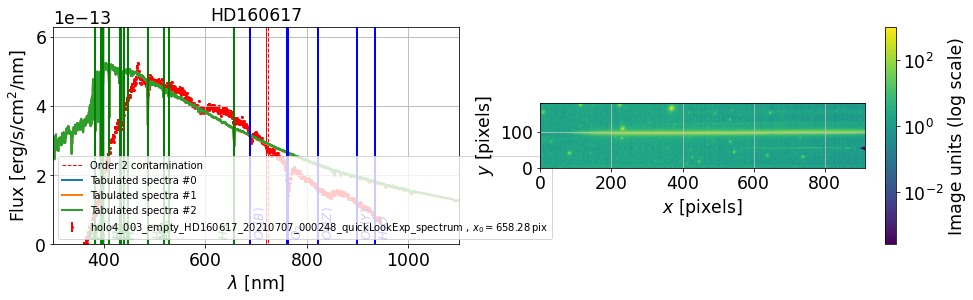

1 ) holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits


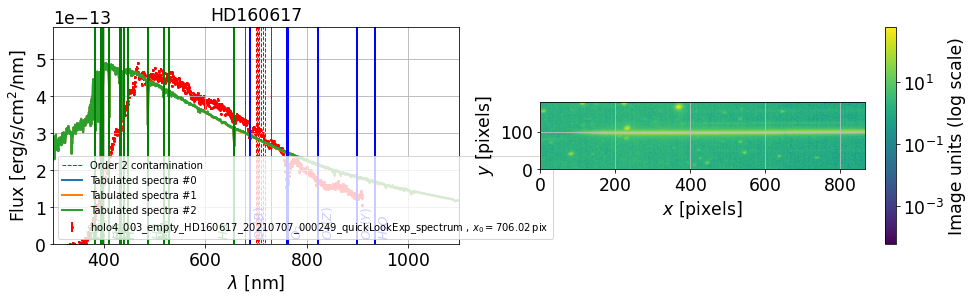

2 ) holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits


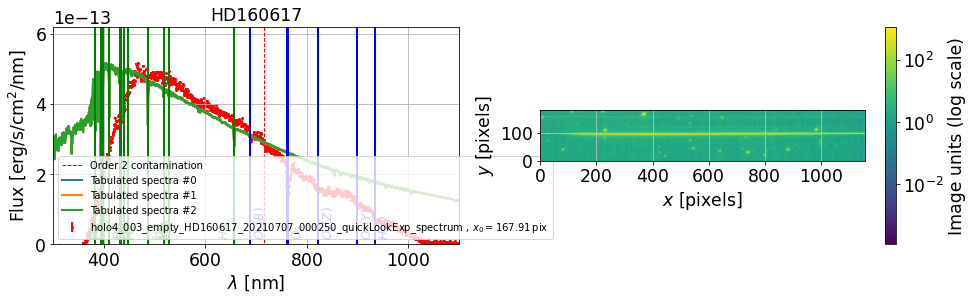

3 ) holo4_003_empty_HD160617_20210707_000251_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000251_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000251_quickLookExp_spectrum.fits


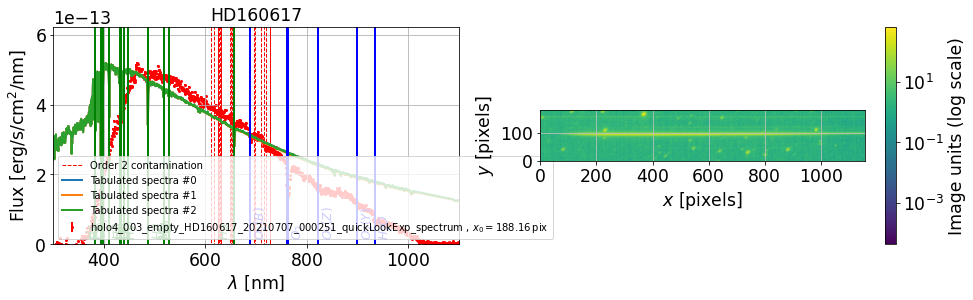

4 ) holo4_003_empty_HD160617_20210707_000252_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000252_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000252_quickLookExp_spectrum.fits


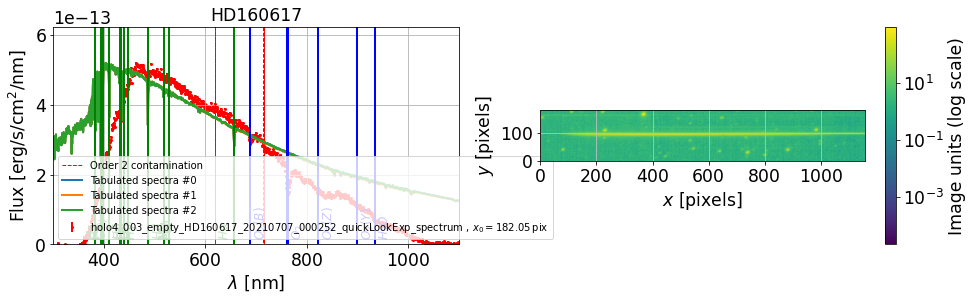

5 ) holo4_003_empty_HD160617_20210707_000285_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000285_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000285_quickLookExp_spectrum.fits


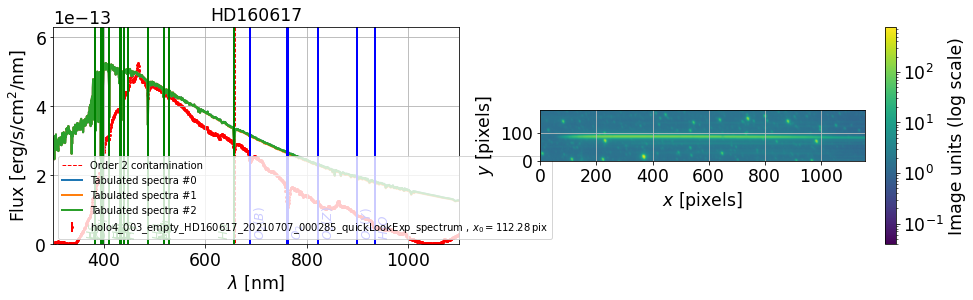

6 ) holo4_003_empty_HD160617_20210707_000286_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000286_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000286_quickLookExp_spectrum.fits


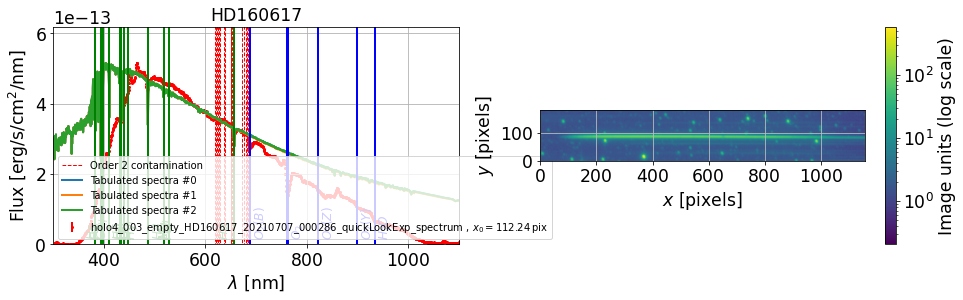

7 ) holo4_003_empty_HD160617_20210707_000287_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000287_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000287_quickLookExp_spectrum.fits


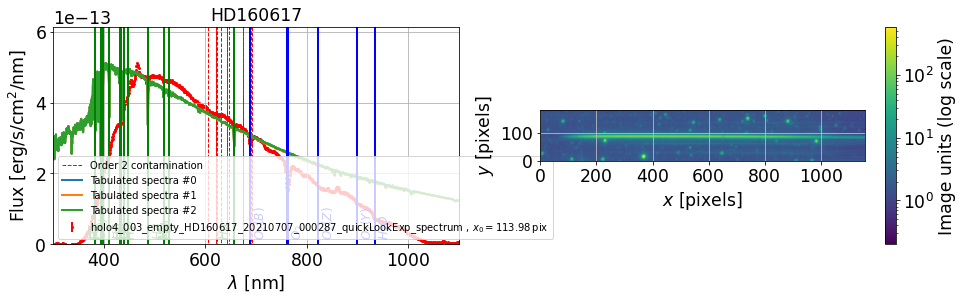

8 ) holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits


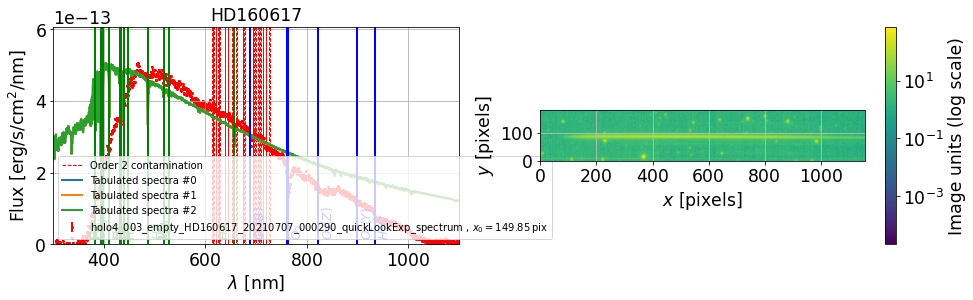

9 ) holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrum.fits


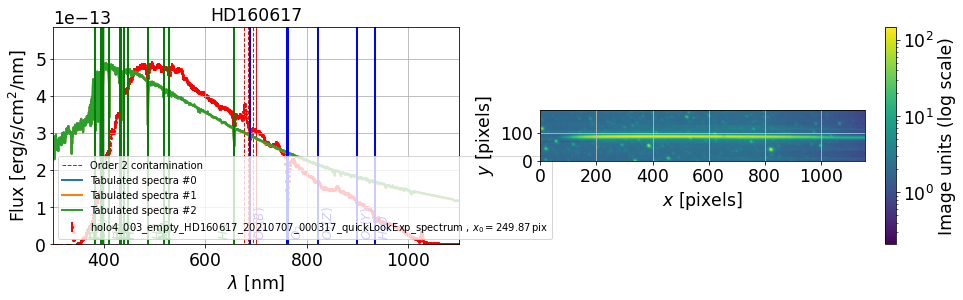

10 ) holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000318_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits


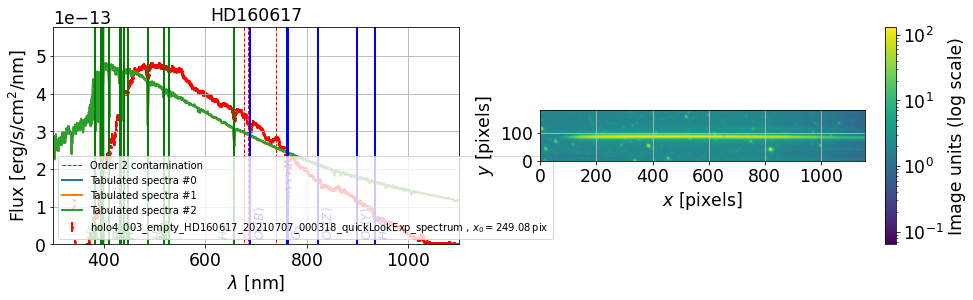

11 ) holo4_003_empty_HD160617_20210707_000319_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000319_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000319_quickLookExp_spectrum.fits


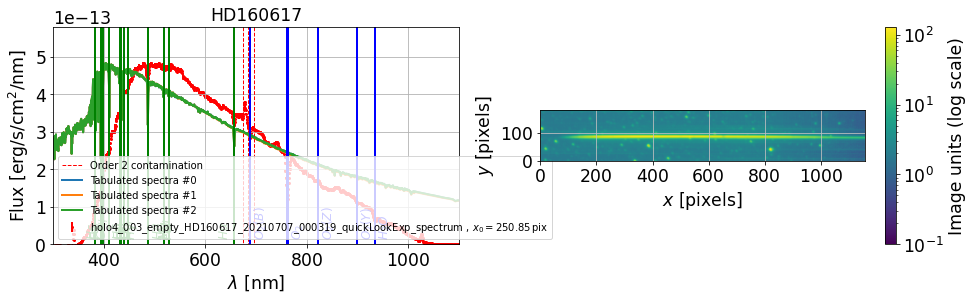

12 ) holo4_003_empty_HD160617_20210707_000320_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000320_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000320_quickLookExp_spectrum.fits


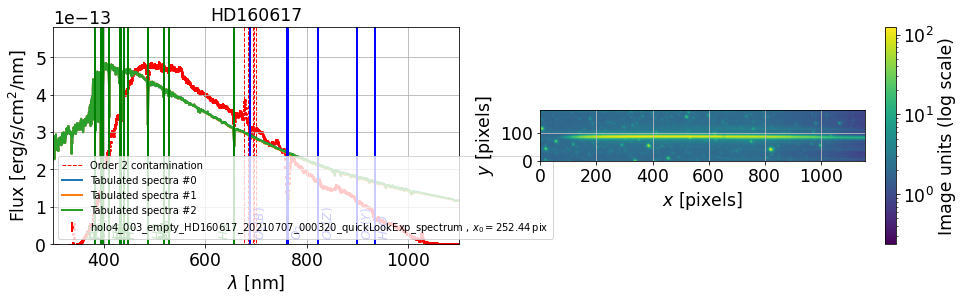

13 ) holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits


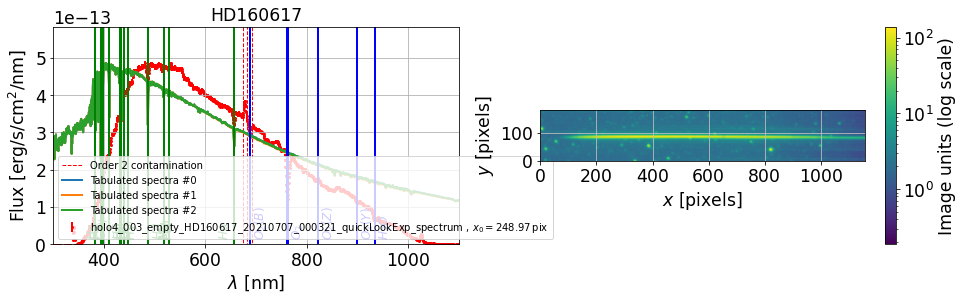

14 ) holo4_003_empty_HD160617_20210707_000322_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000322_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000322_quickLookExp_spectrum.fits


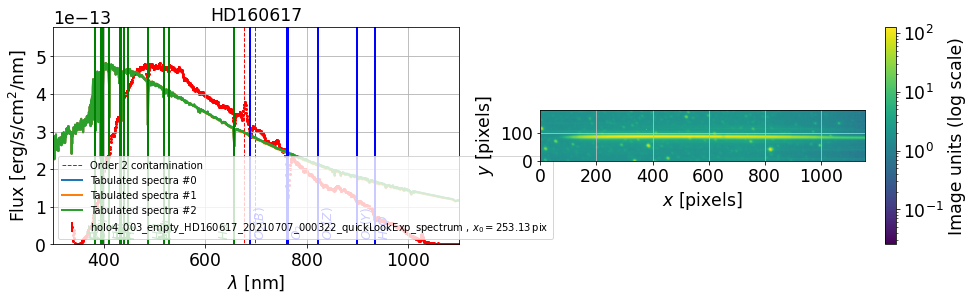

15 ) holo4_003_empty_HD160617_20210707_000323_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000323_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000323_quickLookExp_spectrum.fits


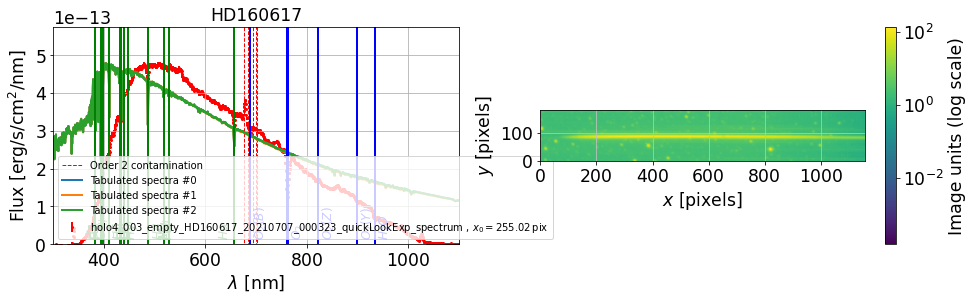

16 ) holo4_003_empty_HD160617_20210707_000324_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000324_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000324_quickLookExp_spectrum.fits


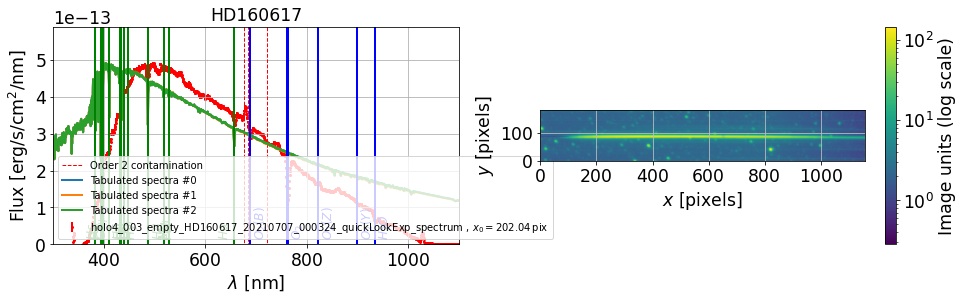

17 ) holo4_003_empty_HD160617_20210707_000325_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000325_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000325_quickLookExp_spectrum.fits


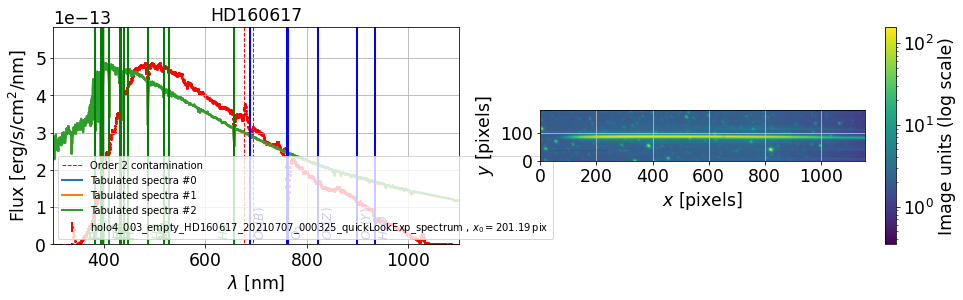

18 ) holo4_003_empty_HD160617_20210707_000326_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000326_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000326_quickLookExp_spectrum.fits


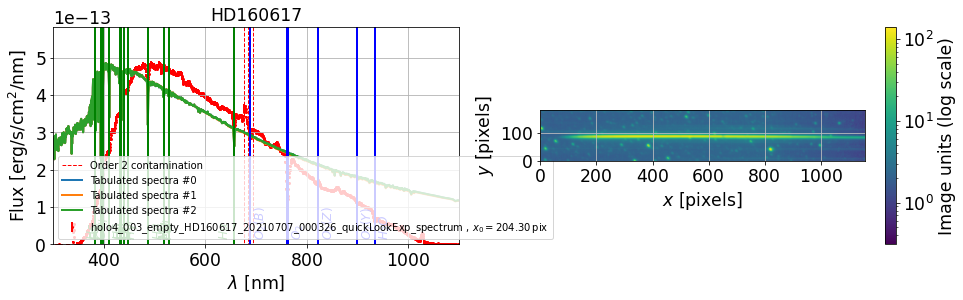

19 ) holo4_003_empty_HD160617_20210707_000328_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000328_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000328_quickLookExp_spectrum.fits


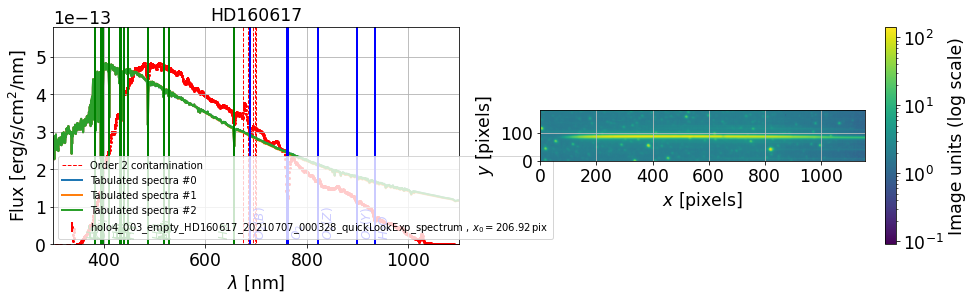

20 ) holo4_003_empty_HD160617_20210707_000329_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000329_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000329_quickLookExp_spectrum.fits


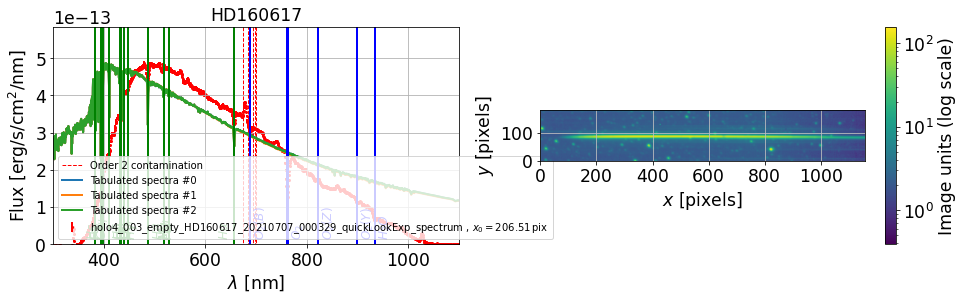

21 ) holo4_003_empty_HD160617_20210707_000330_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000330_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000330_quickLookExp_spectrum.fits


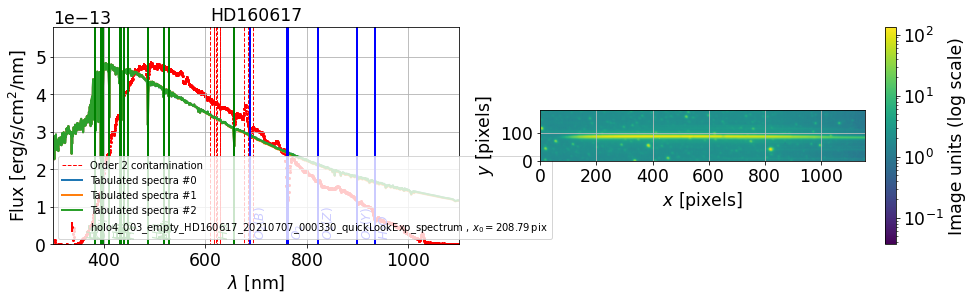

22 ) holo4_003_empty_HD160617_20210707_000331_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000331_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000331_quickLookExp_spectrum.fits


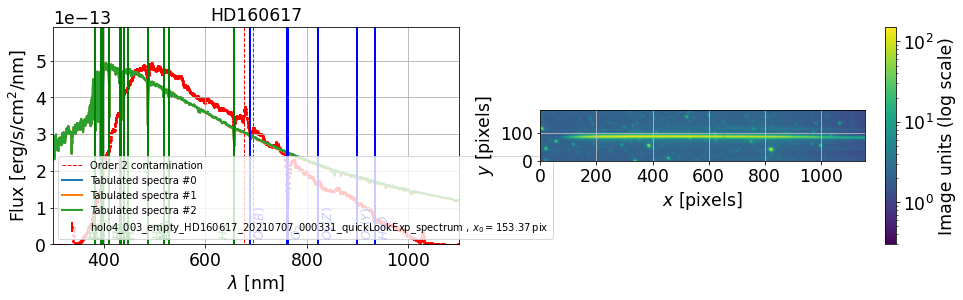

23 ) holo4_003_empty_HD160617_20210707_000332_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000332_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000332_quickLookExp_spectrum.fits


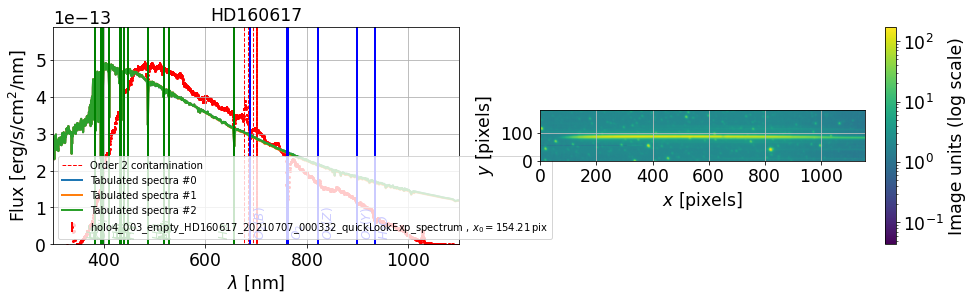

24 ) holo4_003_empty_HD160617_20210707_000334_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000334_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000334_quickLookExp_spectrum.fits


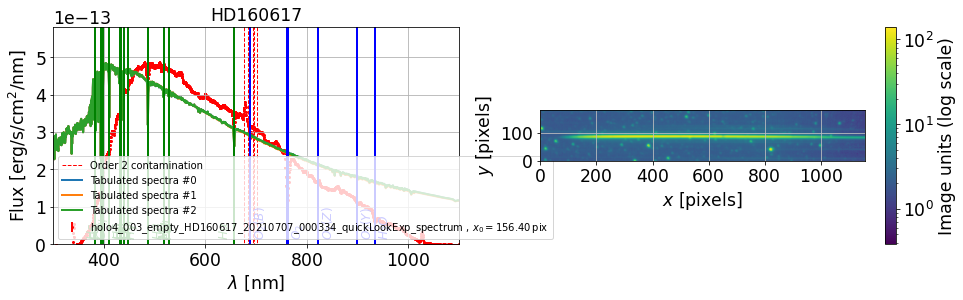

25 ) holo4_003_empty_HD160617_20210707_000335_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000335_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000335_quickLookExp_spectrum.fits


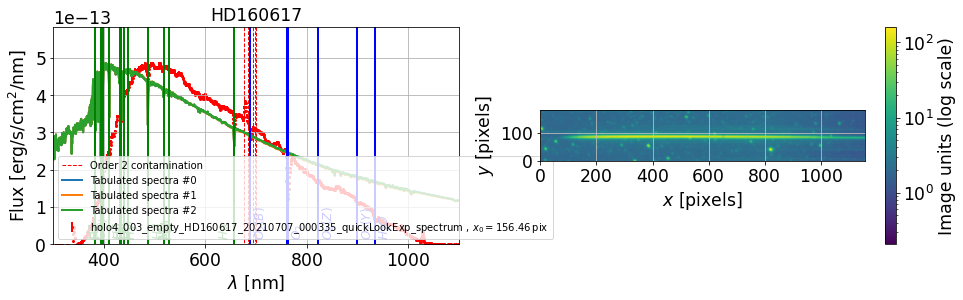

26 ) holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000336_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits


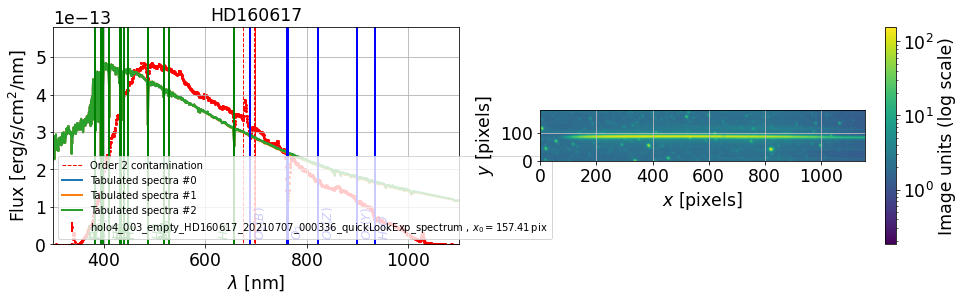

27 ) holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits


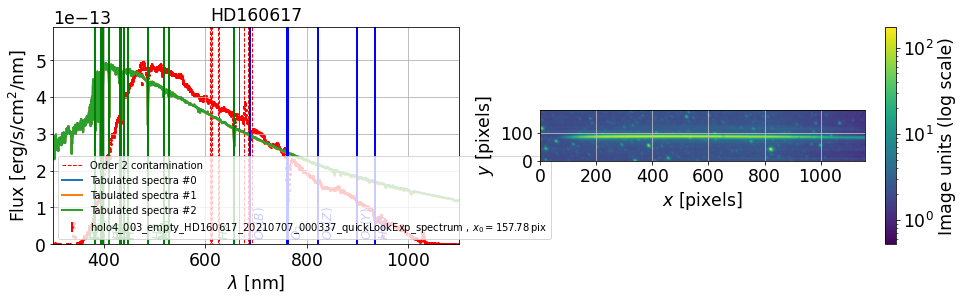

28 ) holo4_003_empty_HD160617_20210707_000338_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000338_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000338_quickLookExp_spectrum.fits


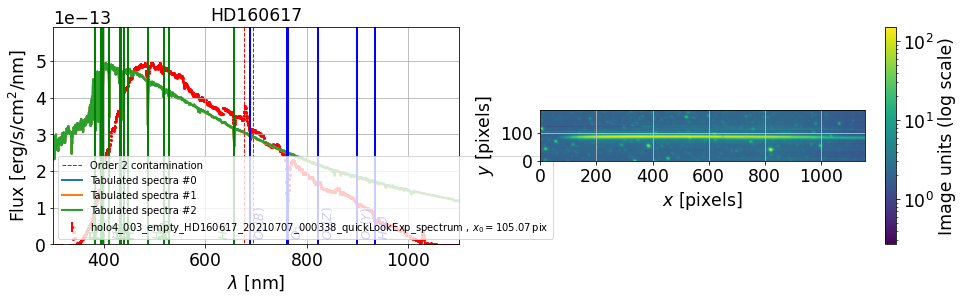

29 ) holo4_003_empty_HD160617_20210707_000339_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000339_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000339_quickLookExp_spectrum.fits


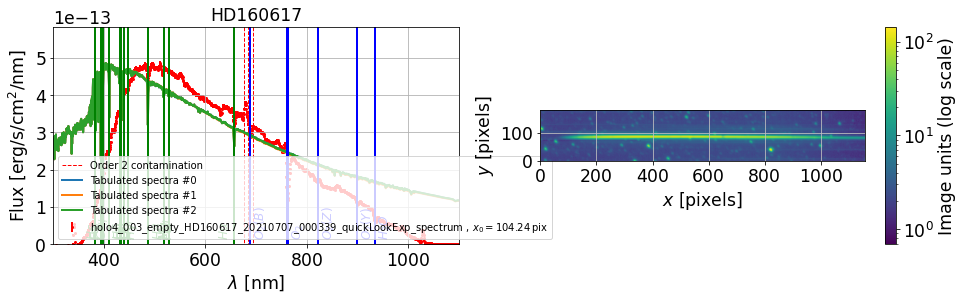

30 ) holo4_003_empty_HD160617_20210707_000340_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000340_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000340_quickLookExp_spectrum.fits


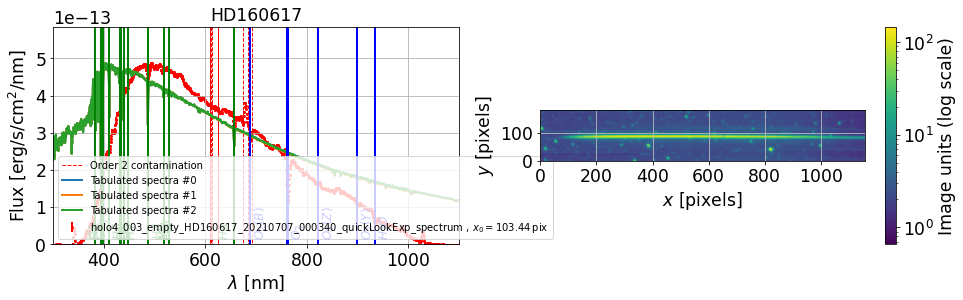

31 ) holo4_003_empty_HD160617_20210707_000341_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000341_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000341_quickLookExp_spectrum.fits


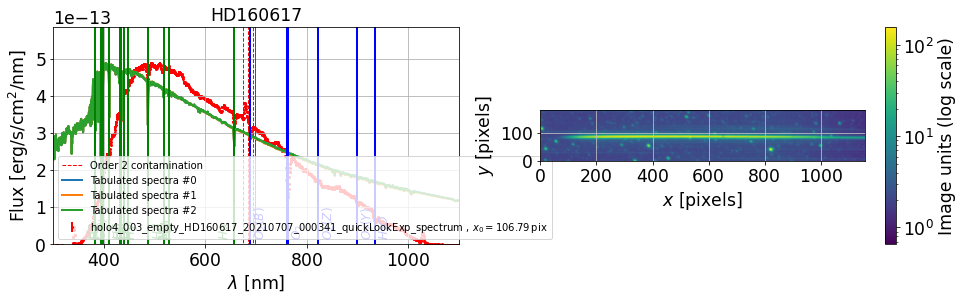

32 ) holo4_003_empty_HD160617_20210707_000342_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000342_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000342_quickLookExp_spectrum.fits


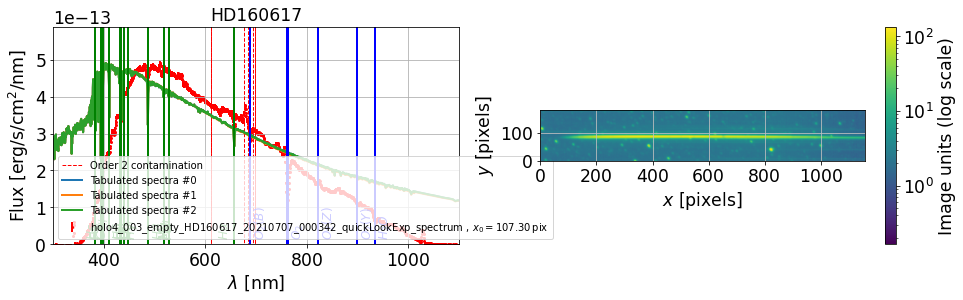

33 ) holo4_003_empty_HD160617_20210707_000343_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000343_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000343_quickLookExp_spectrum.fits


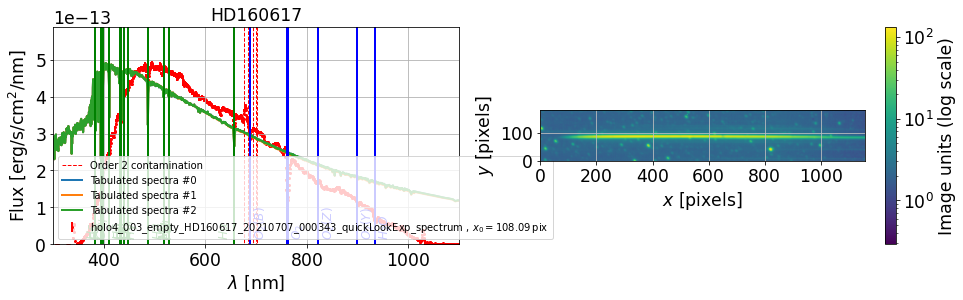

34 ) holo4_003_empty_HD160617_20210707_000344_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000344_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000344_quickLookExp_spectrum.fits


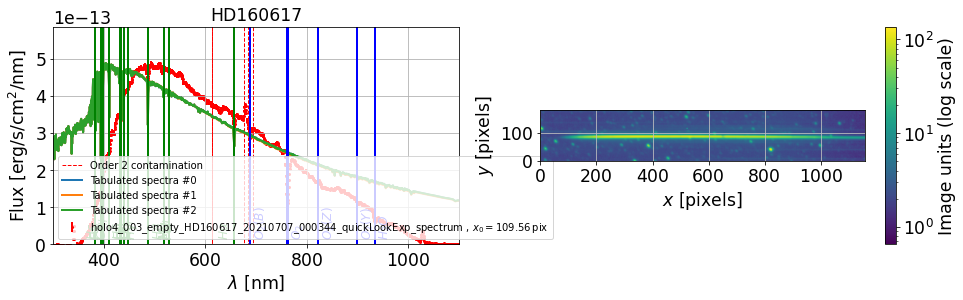

35 ) holo4_003_empty_HD160617_20210707_000345_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000345_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000345_quickLookExp_spectrum.fits


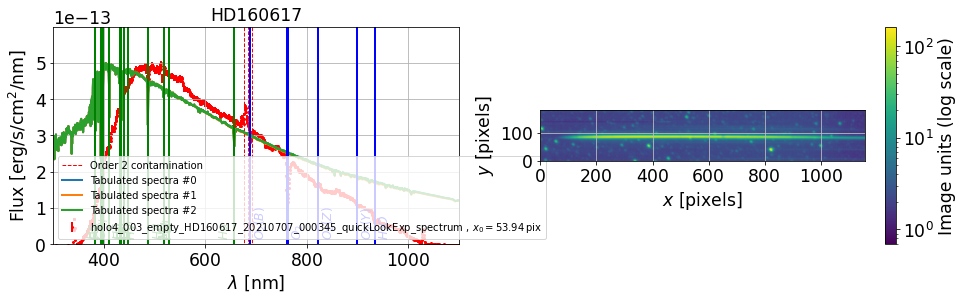

36 ) holo4_003_empty_HD160617_20210707_000346_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000346_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000346_quickLookExp_spectrum.fits


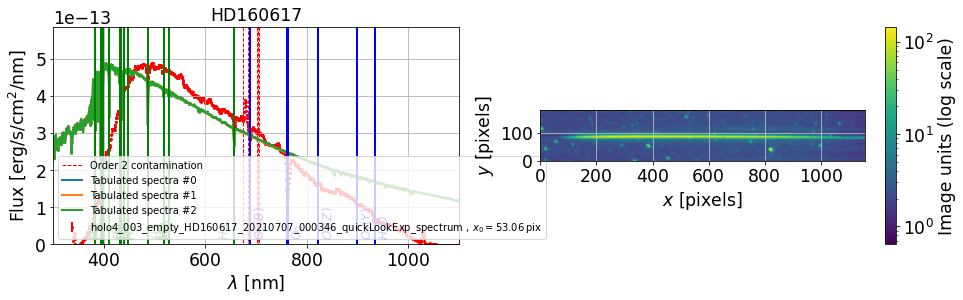

37 ) holo4_003_empty_HD160617_20210707_000347_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000347_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000347_quickLookExp_spectrum.fits


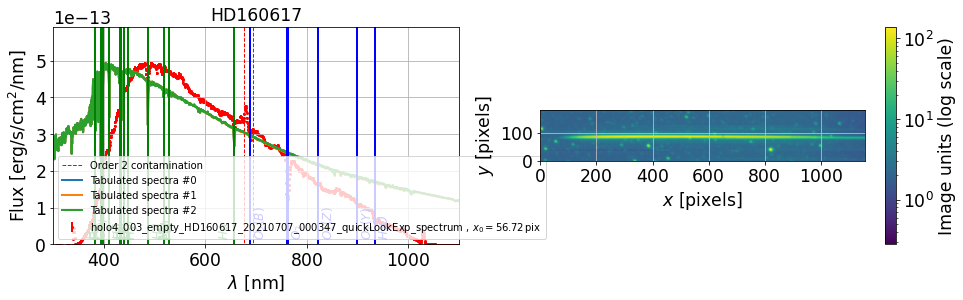

38 ) holo4_003_empty_HD160617_20210707_000348_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000348_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000348_quickLookExp_spectrum.fits


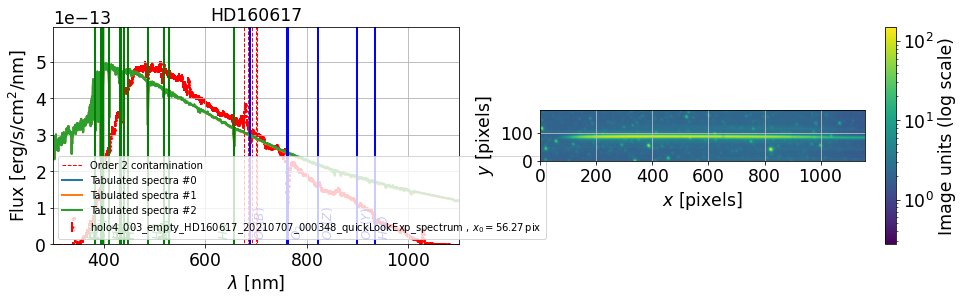

39 ) holo4_003_empty_HD160617_20210707_000349_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000349_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000349_quickLookExp_spectrum.fits


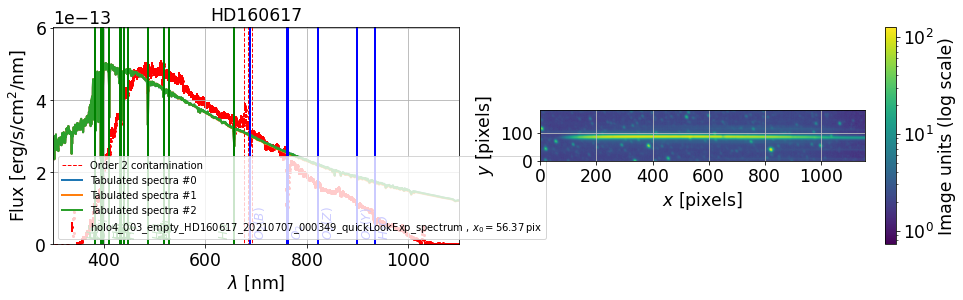

In [45]:
parameters.DISPLAY=False

infos = []
all_lambdas=[]
all_data=[]
all_num=[]

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    filename = os.path.basename(fullfilename)
    
    print(idx,")",filename," ",fullfilename)
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

# Extract information from scan

In [46]:
from astropy.io import fits

idx=0
all_X=[]
all_Y=[]
all_angle=[]
all_tag=[]

for fullfilename in all_good_spectra_spectrum_files:
    
    # avoid simad timeout
    #s=Spectrum(fullfilename, config=config,fast_load=False)
    #header=s.header
    
    filename=os.path.basename(fullfilename)
    tagname=file_tag_forsorting(filename)
    tag=int(tagname)
    tagname=str(tag)
    #all_tag.append(tagname)
    all_tag.append(tag)
    hdul = fits.open(fullfilename)
    #hdul.info()
    header=hdul[0].header
    angle=header["ROTANGLE"]
    X=header["TARGETX"]
    Y=header["TARGETY"]
    all_X.append(X)
    all_Y.append(Y)
    all_angle.append(angle)
    
all_X=np.array(all_X)
all_Y=np.array(all_Y)
all_angle=np.array(all_angle)
all_tag=np.array(all_tag)

In [47]:
def plotScanAngle(X,Y,ang,tag,xlims=(0,4000),ylims=(0,4000),flag_annotate=True,figsize=(12,12),title=""):
    """
    """
    plt.figure(figsize=figsize)
    
    sc = plt.scatter(X, Y, s=200, c=ang, cmap="seismic")
    plt.colorbar(sc)
    
    if flag_annotate:
        K=len(tag)
        for idx in range(K):
            plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k", ha='center',va='top',fontsize=15)
            #plt.annotate(tag[idx],xy=(X[idx],Y[idx]), color="k",fontsize=10)
            #plt.text(X[idx],Y[idx],tag[idx],  horizontalalignment='center',verticalalignment='top',color="k",fontsize=10)
        
    
    plt.xlim(xlims)  
    plt.ylim(ylims)  
    
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    axes=plt.gca()
    axes.set_aspect('equal')
    
    plt.title(title)
    plt.tight_layout()
    
    plt.show()
            

### Extract narrow scan

In [48]:
IdxNarrowScan=np.where(all_tag>=317)[0]

In [49]:
all_X_nr=all_X[IdxNarrowScan]
all_Y_nr=all_Y[IdxNarrowScan]
all_angle_nr=all_angle[IdxNarrowScan]
all_tag_nr=all_tag[[IdxNarrowScan]]

<ipython-input-49-70405a380c6f>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  all_tag_nr=all_tag[[IdxNarrowScan]]


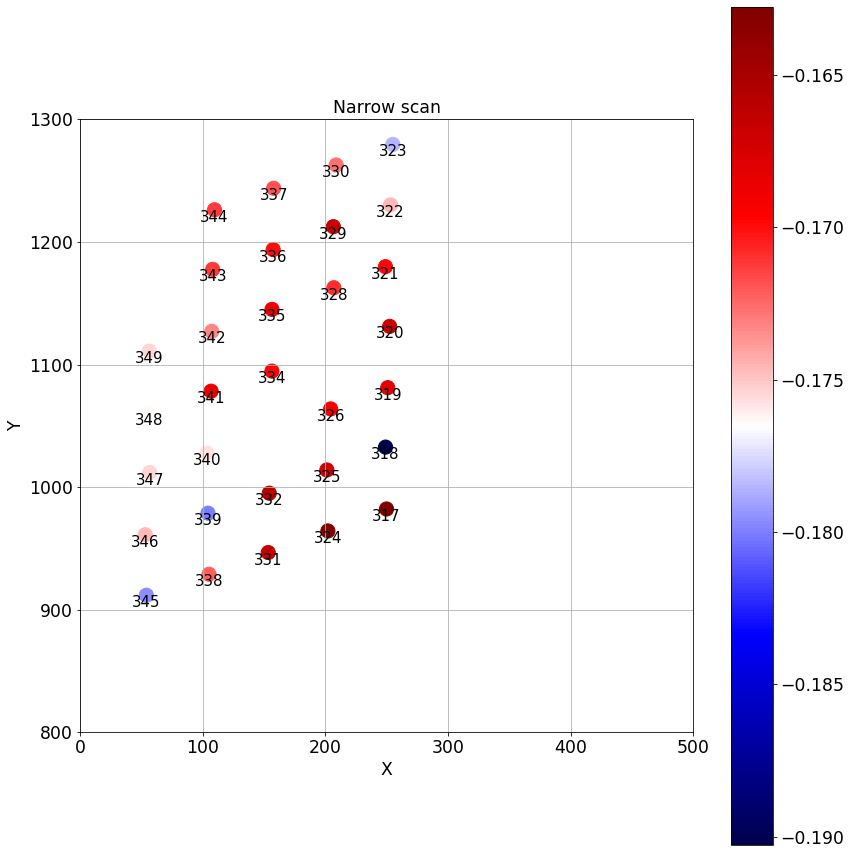

In [50]:
plotScanAngle(all_X_nr,all_Y_nr,all_angle_nr,all_tag_nr,xlims=(0,500),ylims=(800,1300),title="Narrow scan")

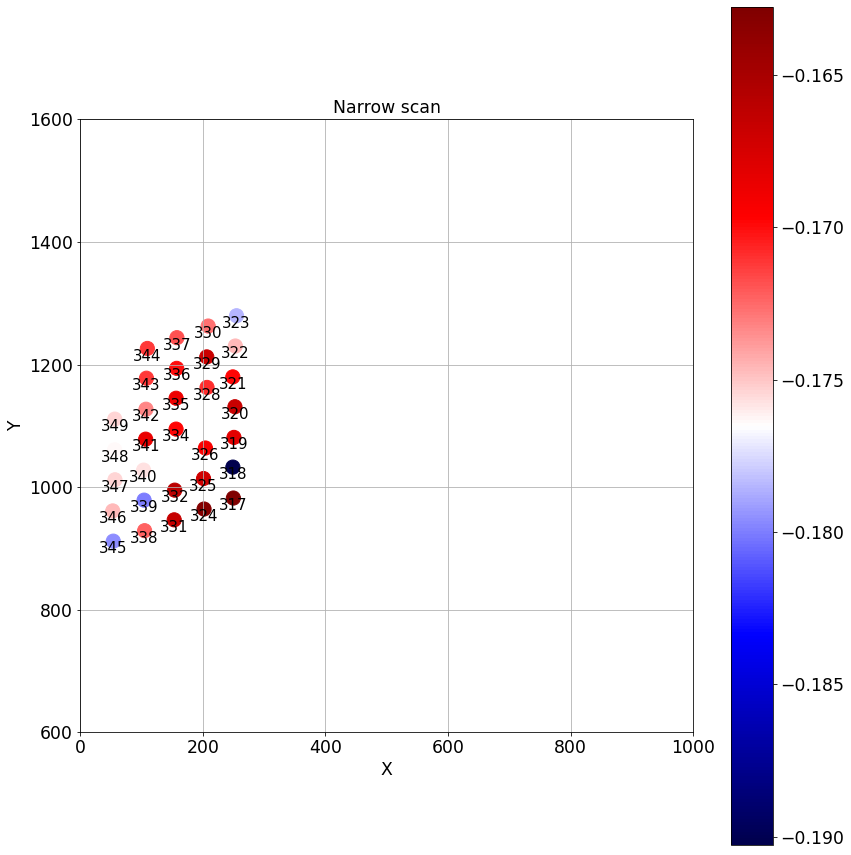

In [51]:
plotScanAngle(all_X_nr,all_Y_nr,all_angle_nr,all_tag_nr,xlims=(0,1000),ylims=(600,1600),title="Narrow scan")

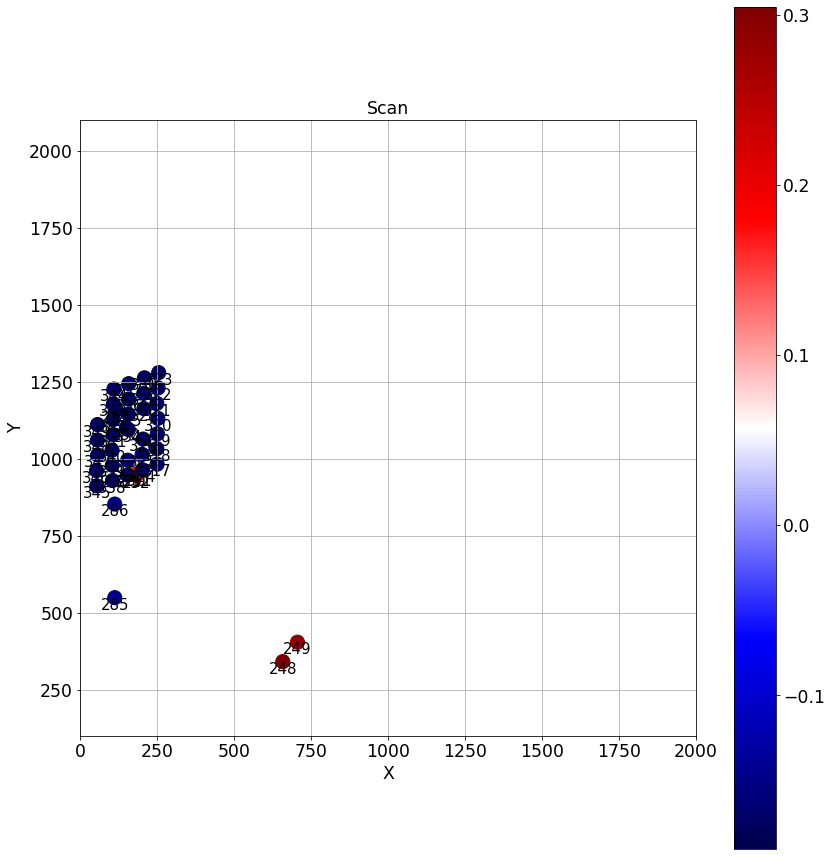

In [52]:
plotScanAngle(all_X,all_Y,all_angle,all_tag,xlims=(0,2000),ylims=(100,2100),title="Scan")

# Save files

In [53]:
file_csv="narrowscan_2021-07-07.csv"
file_xlsx="narrowscan_2021-07-07.xlsx"

In [54]:
df= pd.DataFrame()

In [55]:
df["X(mm)"]=all_X_nr*0.01
df["Y(mm)"]=all_Y_nr*0.01
df["degré"]=all_angle_nr
df["tag"]=all_tag_nr
df["Xpix"]=all_X_nr
df["Ypix"]=all_Y_nr

In [56]:
df.to_excel(file_xlsx)
df.to_csv(file_csv)